# Shear strength envelopes

© 2022 Exneyder A. Montoya-Araque, Daniel F. Ruiz and Universidad EAFIT.

This notebook can be interactively run in [Google - Colab](https://colab.research.google.com/github/AppliedMechanics-EAFIT/EAFIT_slope_stability/blob/main/notebooks/strength_envelopes.ipynb).



## Required modules

In [1]:
import ast # helps with converting str representation of python data structures
import numpy as np
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
import matplotlib as mpl
from ipywidgets import widgets as wgt
from IPython import get_ipython
from IPython.display import display

if 'google.colab' in str(get_ipython()):
    print('Running on CoLab. Installing the required modules...')
    from subprocess import run
    run('pip install ipympl', shell=True);
    from google.colab import output
    output.enable_custom_widget_manager()

%matplotlib widget

plt.style.use("default")
colors = ("#DDAA33", "#BB5566", "#004488")
mpl.rcParams.update(
    {
        'figure.constrained_layout.use': True,
        'interactive': False,
        "text.usetex": False,  # Use mathtext, not LaTeX
        "font.family": "cmr10",  # Use the Computer modern font
        "mathtext.fontset": "cm",
        "axes.formatter.use_mathtext": True,
        "axes.unicode_minus": False,
    }
)
html_setup = '<style> div.jupyter-widgets.widget-label {display: none;} </style>'

In [2]:
def strength_envelope(normal_stress, shear_stress, plot_parabola=False,
                      plot_tang2parab=False, sigma_n=150, widget=False, **kwargs):
    if type(normal_stress) == str:  # This is for interpreting in from the widget
        normal_stress = ast.literal_eval(f"[{normal_stress}]")
    if type(shear_stress) == str:  # This is for interpreting in from the widget
        shear_stress = ast.literal_eval(f"[{shear_stress}]")
    min_id = min(len(normal_stress), len(shear_stress))
    normal_stress, shear_stress = normal_stress[:min_id], shear_stress[:min_id]

    line_parameters = polyfit(normal_stress, shear_stress, deg=1)
    c, tan_phi = line_parameters
    phi = np.degrees(np.arctan(tan_phi))
    envelope_MC = np.poly1d(np.flip(line_parameters))

    parab_param = polyfit(normal_stress, shear_stress, deg=2)
    envelope_parab = np.poly1d(np.flip(parab_param))

    tan_phi_parab = np.tan(2 * parab_param[-1] * sigma_n + parab_param[-2])
    phi_par = np.degrees(np.arctan(tan_phi_parab))
    c_parab = envelope_parab(sigma_n) - tan_phi_parab * sigma_n
    line_parameters_parab = (c_parab, tan_phi_parab)
    envelope_MC_parab = np.poly1d(np.flip(line_parameters_parab))

    sigma2plot = np.linspace(0, max(normal_stress) * 1.3, 50)
    # stress vs horizontal deformation plot
    fig = plt.figure(figsize=kwargs.get('figsize', [7, 4]))
    ax = fig.add_subplot(111)
    ax.plot(sigma2plot, envelope_MC(sigma2plot), ls="-", color="k",
            label="$\\tau=" + f"{c:.1f}" + "+\\tan(" + f"{phi:.1f}"
            + "^\\circ )\\sigma_\\mathrm{n}$")
    if plot_parabola:
        ax.plot(sigma2plot, envelope_parab(sigma2plot), ls="--", color='b',
            label="Parabola fitting")
    if plot_tang2parab:
        ax.plot(sigma2plot, envelope_MC_parab(sigma2plot), ls="--", color='r',
            label="$\\tau_\mathrm{\\sigma_\\mathrm{n}^\star}=" + f"{c_parab:.1f}"
            + "+\\tan(" + f"{phi_par:.1f}" + "^\\circ )\\sigma_\\mathrm{n}$")
        ax.plot(sigma_n, envelope_MC_parab(sigma_n), ls="", marker="*", ms=12,
                color='k', label="$\\sigma_\\mathrm{n}^\star$")
    ax.plot(normal_stress, shear_stress, ls='', marker="o", mec='k', mfc='w', ms=7,
            label='Data')
    ax.set_xlabel("normal stress, $\\sigma_\\mathrm{n}$   [$\\mathrm{kPa}$]")
    ax.set_ylabel("shear stress $\\tau$   [$\\mathrm{kPa}$]")
    tau_max = max(shear_stress)
    sig_max = max(shear_stress)
    ax.axis("image")
    ax.set_ylim(
        (0, max(tau_max, envelope_MC(sigma2plot[-1]), envelope_parab(sigma2plot[-1]))))
    ax.set_xlim((0, sigma2plot[-1]))
    ax.grid(True, ls="--", lw=0.5)
    ax.spines["bottom"].set_linewidth(1.5)
    ax.spines["left"].set_linewidth(1.5)
    ax.legend()
    if widget:
        display(fig)
    else:
        plt.show()
        display(wgt.HTML(html_setup))
    plt.close()
    if plot_tang2parab:
        return np.round((phi, c), 1)


In [3]:
s, l = {'description_width': '200'}, wgt.Layout(width='450px')
s_tan, l_tan = {'description_width': '5'}, wgt.Layout(width='320px')
controls = {
    'normal_stress': wgt.Text(value="100, 200, 400", description="𝜎ₙ", style=s, layout=l),
    'shear_stress': wgt.Text(value="80, 145, 250", description="𝜏ₙ", style=s, layout=l),
    'plot_parabola': wgt.Checkbox(value=False, description="Plot parabola fitting?", style=s, layout=l),
    'plot_tang2parab': wgt.Checkbox(value=False, description="Plot tangent to parabola at 𝜎ₙ★?", style=s_tan, layout=l_tan),
    'sigma_n': wgt.FloatSlider(value=250, min=0, max=500, step=0.2, description="𝜎ₙ★", style=s_tan, layout=wgt.Layout(width='300px')),
    'widget': wgt.Checkbox(value=True, description='Non-vector image (improve widget performance)', style=s, layout=l)
}
c_all = list(controls.values())
c_tan = [wgt.HBox(c_all[3:5])]
c = c_all[:3] + c_tan + c_all[5:]
fig = wgt.interactive_output(strength_envelope, controls)
wgt.HBox((wgt.VBox(c), fig), layout=wgt.Layout(align_items='center'))

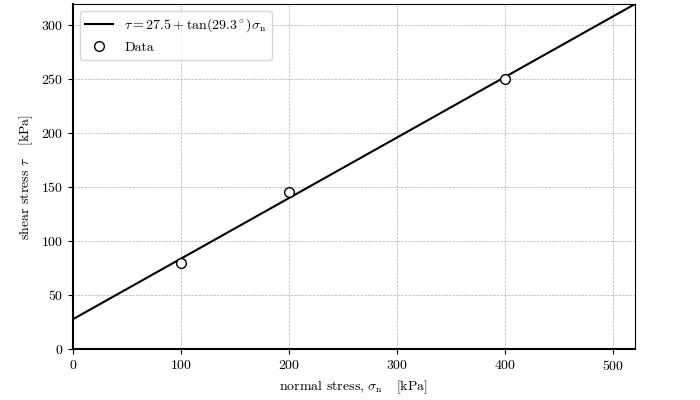

HTML(value='<style> div.jupyter-widgets.widget-label {display: none;} </style>')

In [4]:
strength_envelope(
    normal_stress=[100, 200, 400],
    shear_stress=[80, 145, 250],
    plot_parabola=False,
    plot_tang2parab=False,
    sigma_n=150,
)
